# UIUC Grid Demand: Demand + Solar Elevation Angle

This notebook uses an Echo State Network(ESN) (from pyESN) to predict the demand at the University of Illinois.
Rather than one input, there are two inputs: Demand and Solar Elevation Angle. 
The following items are included:

1. An initial demonstration of the ESN with a 72-hour prediction.
2. Grid optimization over spectral radius and noise
3. Grid optimization over reservoir size and sparsity
4. Demonstrate the effect of training length on accuracy.
5. A final demonstration of the ESN with optimized hyper-parameters.

In [1]:
import platform 
operating_system = platform.system()
print(operating_system)

Windows


In [2]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import sys
if operating_system is 'Linux':
    sys.path.insert(0, "/home/dotson/research/cairo")
elif operating_system is 'Windows':
    sys.path.insert(0, "C:/users/samgd/research/cairo")


# custom libraries
from tools import MSE, esn_prediction, param_string, optimal_values
from optimizers import grid_optimizer
from sunrise import generate_elevation_series
from pyESN.pyESN import ESN

In [3]:
# import demand data
dataframe = pd.read_csv("../data/uiuc_demand_data.csv", usecols=['time','kw'])
demand = np.array(dataframe.kw).astype('float64')

# normalize
norm = np.linalg.norm(demand)
demand_norm = demand/norm

In [4]:
time_range = pd.date_range(start='1/1/2015', end='7/1/2019', freq='h')[:-2]
elevation = generate_elevation_series(time_range, timestamps=True)
norm_a = np.linalg.norm(elevation)
angles_norm = elevation/norm_a
print(f"Norm of elevation angles: {norm_a}")
print(f"Norm of demand: {norm}")

Norm of elevation angles: 7170.040655802196
Norm of demand: 10142199.043147163


## Format the Input Data

In [5]:
X_in = np.concatenate([[demand_norm, angles_norm]], axis=1)
    
print(f"Shape of X_in is {X_in.shape}")

Shape of X_in is (2, 39407)


In [6]:
params = {'n_reservoir':1000, 
          'sparsity':0.1, 
          'rand_seed':85, 
          'rho':1.5, 
          'noise':0.0001, 
          'future':72, 
          'window':24, 
          'trainlen':8000}

In [7]:
futureTotal = params['future']
time_range = np.array(dataframe.time)
hour_range = np.arange(0, len(time_range), 1)

## 1. Initial Demonstration


In [8]:
tic = time.perf_counter()

init_pred = esn_prediction(X_in.T, params)

toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds")
print(f"This simulation took {elapsed/60:0.02f} minutes")

This simulation took 11.52 seconds
This simulation took 0.19 minutes


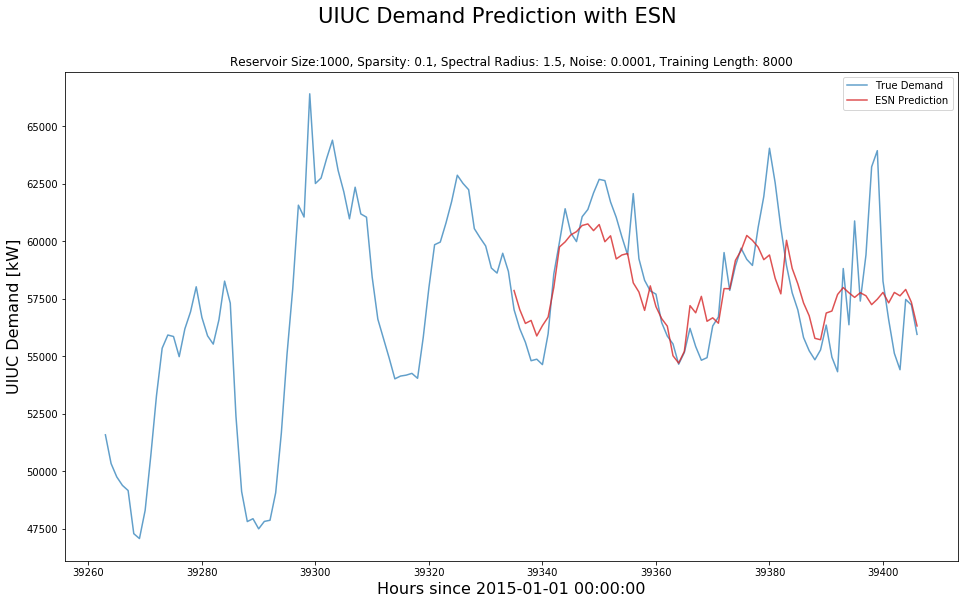

In [9]:
plt.figure(figsize=(16,9))
plt.suptitle("UIUC Demand Prediction with ESN", fontsize=21)
plt.title(param_string(params))
plt.ylabel("UIUC Demand [kW]", fontsize=16)
plt.xlabel(f"Hours since {time_range[0]}", fontsize=16)
# plot the truth
plt.plot(hour_range[-2*futureTotal:],norm*demand_norm[-2*futureTotal:],'b',label="True Demand", 
         alpha=0.7,
         color='tab:blue')
# # plot the prediction
plt.plot(hour_range[-futureTotal:], norm*init_pred.T[0],  alpha=0.8, 
         label='ESN Prediction',
         color='tab:red',
         linestyle='-')
plt.legend()

### 2. Grid Optimization Over Spectral Radius and Noise

Optimizing over ['rho', 'noise']:
rho = 0.5, noise = 0.0001, MSE=0.0027098023266782668
rho = 0.5, noise = 0.0003, MSE=0.0027153570579060396
rho = 0.5, noise = 0.0007, MSE=0.002744140194756859
rho = 0.5, noise = 0.001, MSE=0.0027272407505250116
rho = 0.5, noise = 0.003, MSE=0.0030731850495587256
rho = 0.5, noise = 0.005, MSE=0.0037030935282393873
rho = 0.5, noise = 0.007, MSE=0.004270324680967047
rho = 0.5, noise = 0.01, MSE=0.00482303267196038
rho = 0.7, noise = 0.0001, MSE=0.0021899217745645965
rho = 0.7, noise = 0.0003, MSE=0.0025441694730414647
rho = 0.7, noise = 0.0007, MSE=0.0026455159162062716
rho = 0.7, noise = 0.001, MSE=0.002702637759302701
rho = 0.7, noise = 0.003, MSE=0.002905428527762997
rho = 0.7, noise = 0.005, MSE=0.003300919543547874
rho = 0.7, noise = 0.007, MSE=0.0037634593030070333
rho = 0.7, noise = 0.01, MSE=0.004360737852203139
rho = 0.9, noise = 0.0001, MSE=0.000934011382283261
rho = 0.9, noise = 0.0003, MSE=0.0015885025223210988
rho = 0.9, noise = 0.0007, MSE=0.

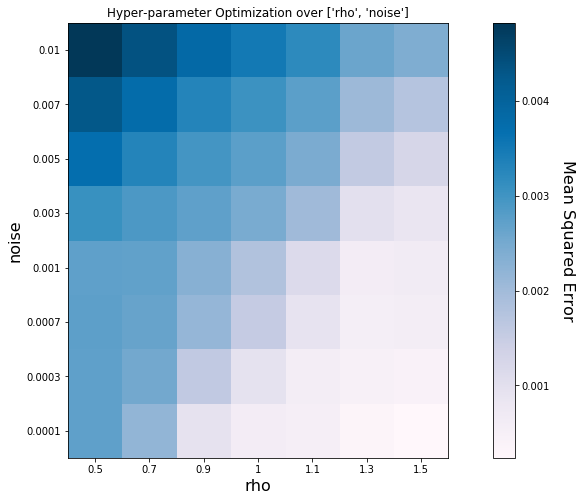

In [10]:
tic = time.perf_counter()
radius_set = [0.5, 0.7, 0.9,  1,  1.1,1.3,1.5]
noise_set = [ 0.0001, 0.0003,0.0007, 0.001, 0.003, 0.005, 0.007,0.01]

radiusxnoise_loss = grid_optimizer(X_in.T,
                      params,
                      args=['rho', 'noise'],
                      xset=radius_set,
                      yset=noise_set,
                      verbose=True,
                      visualize=True)

toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds")
print(f"This simulation took {elapsed/60:0.02f} minutes")

In [11]:
opt_radius, opt_noise = optimal_values(radiusxnoise_loss, radius_set, noise_set)
params['rho'] = opt_radius
params['noise'] = opt_noise
print(f'The optimal set is:\nspectrum radius = {opt_radius} \nnoise = {opt_noise}')

The optimal set is:
spectrum radius = 1.5 
noise = 0.0001


### 3. Grid Optimization Over Reservoir Size and Sparsity

The algorithm is unstable when ``n_reservoir == trainlen``.

Optimizing over ['n_reservoir', 'sparsity']:
n_reservoir = 600, sparsity = 0.005, MSE=0.0004165016066412592
n_reservoir = 600, sparsity = 0.01, MSE=0.0004922437403986491
n_reservoir = 600, sparsity = 0.03, MSE=0.00045856536546939517
n_reservoir = 600, sparsity = 0.05, MSE=0.0003727654128955482
n_reservoir = 600, sparsity = 0.1, MSE=0.0002631087757216563
n_reservoir = 600, sparsity = 0.15, MSE=0.0004130526646566789
n_reservoir = 600, sparsity = 0.2, MSE=0.0003502743420004713
n_reservoir = 800, sparsity = 0.005, MSE=0.0001883628661580372
n_reservoir = 800, sparsity = 0.01, MSE=0.000236500015219479
n_reservoir = 800, sparsity = 0.03, MSE=0.00020934219267101264
n_reservoir = 800, sparsity = 0.05, MSE=0.00020411673175719123
n_reservoir = 800, sparsity = 0.1, MSE=0.00024202465073675292
n_reservoir = 800, sparsity = 0.15, MSE=0.00021327858575314105
n_reservoir = 800, sparsity = 0.2, MSE=0.00022906465532944887
n_reservoir = 1000, sparsity = 0.005, MSE=0.00020754884061237978
n_reservoir = 1000,

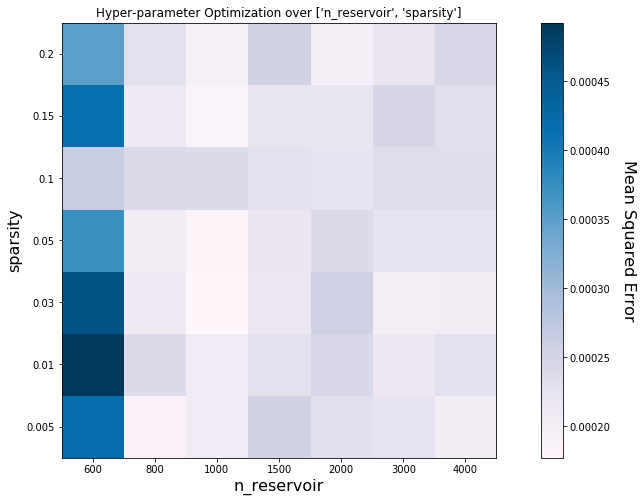

In [12]:
tic = time.perf_counter()
reservoir_set = [600, 800, 1000, 1500, 2000, 3000, 4000]
sparsity_set = [0.005, 0.01, 0.03, 0.05, 0.1, 0.15, 0.2]

sizexsparsity_loss = grid_optimizer(X_in.T,
                      params,
                      args=['n_reservoir', 'sparsity'],
                      xset=reservoir_set,
                      yset=sparsity_set,
                      verbose=True,
                      visualize=True)

toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds")
print(f"This simulation took {elapsed/60:0.02f} minutes")

In [13]:
opt_size, opt_sparsity = optimal_values(sizexsparsity_loss, reservoir_set, sparsity_set)
params['n_reservoir'] = opt_size
params['sparsity'] = opt_sparsity
print(f'The optimal set is:\nreservoir size = {opt_size} \nsparsity = {opt_sparsity}')

The optimal set is:
reservoir size = 1000 
sparsity = 0.03


### 4. Demonstrate the Effect of Training Length

Once again, the algorithm is unstable when ``n_reservoir == trainlen``.

We should expect that MSE will decrease as training length increases.

Optimizing over ['trainlen']:
trainlen = 5000, MSE=0.0002221144984837849
trainlen = 5300, MSE=0.0002397158357010387
trainlen = 5600, MSE=0.00019097071923102887
trainlen = 5900, MSE=0.00023477842099761854
trainlen = 6200, MSE=0.00021968564864034197
trainlen = 6500, MSE=0.00020611510339744774
trainlen = 6800, MSE=0.00024139117597494743
trainlen = 7100, MSE=0.00019713559858295932
trainlen = 7400, MSE=0.00022690547186302856
trainlen = 7700, MSE=0.00021026944243627448
trainlen = 8000, MSE=0.0001772921766918056
trainlen = 8300, MSE=0.00022557868342077593
trainlen = 8600, MSE=0.0001854490522431564
trainlen = 8900, MSE=0.00021406168708834435
trainlen = 9200, MSE=0.00020313330930874125
trainlen = 9500, MSE=0.00022019929711264205
trainlen = 9800, MSE=0.00017907169173713672
trainlen = 10100, MSE=0.00024238432147494305
trainlen = 10400, MSE=0.0002409354644587569
trainlen = 10700, MSE=0.000206884757822028
trainlen = 11000, MSE=0.0002177130988416912
trainlen = 11300, MSE=0.00018015363332717573
train

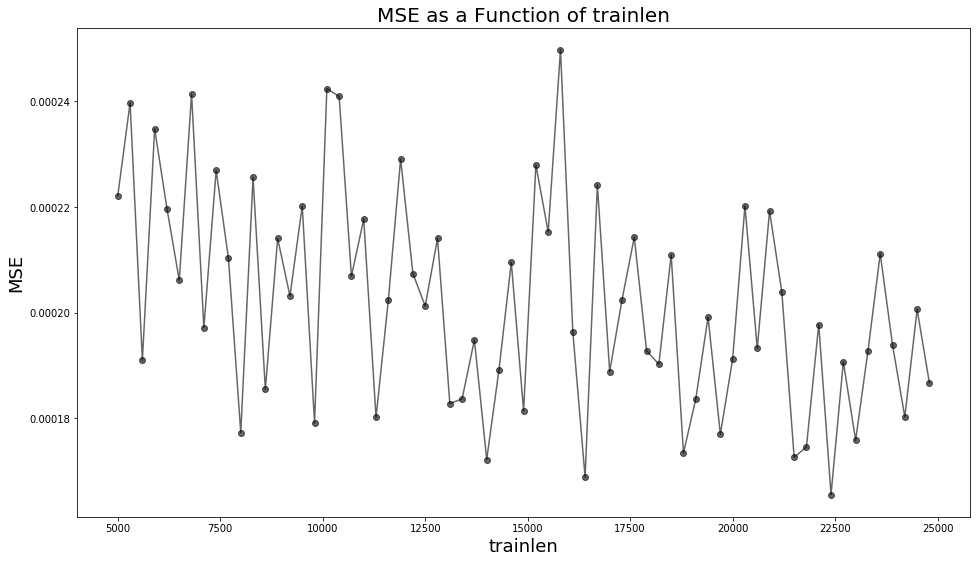

In [14]:
tic = time.perf_counter()
trainingLengths = np.arange(5000,25000,300)
trainlen_loss = grid_optimizer(X_in.T,
                      params,
                      args=['trainlen'],
                      xset=trainingLengths,
                      verbose=True,
                      visualize=True)

toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds") 
print(f"This simulation took {elapsed/60:0.02f} minutes")

In [15]:
minloss = np.min(trainlen_loss)
index_min = np.where(trainlen_loss == minloss)
l_opt = trainingLengths[index_min][0]
params['trainlen'] = l_opt

print(f"Training length with minimum error was: {l_opt}")

Training length with minimum error was: 22400


### 5. Optimized Demand Prediction


In [16]:
tic = time.perf_counter()

opt_pred = esn_prediction(X_in.T, params)

toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds")
print(f"This simulation took {elapsed/60:0.02f} minutes")

This simulation took 11.48 seconds
This simulation took 0.19 minutes


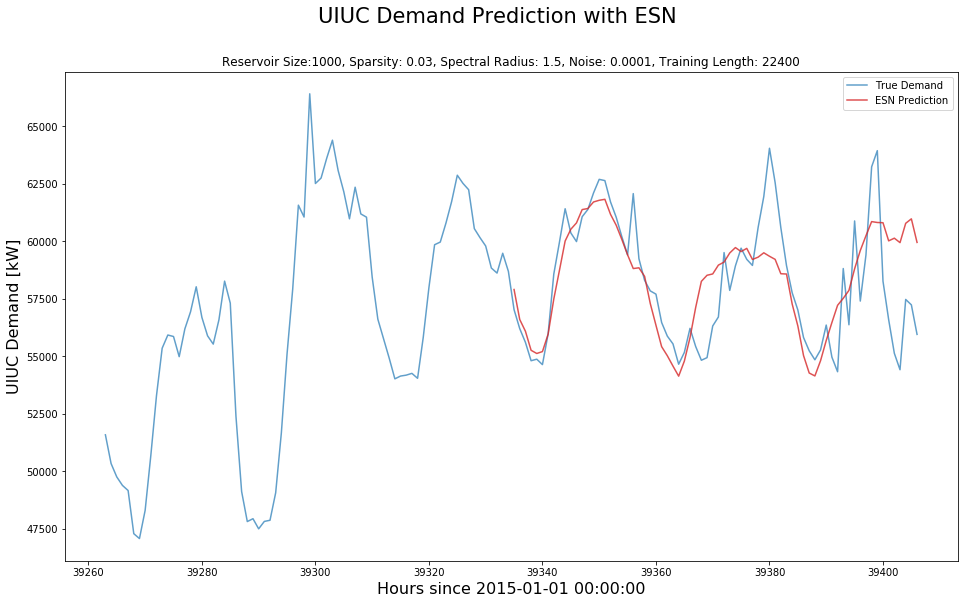

In [17]:
plt.figure(figsize=(16,9))
plt.suptitle("UIUC Demand Prediction with ESN", fontsize=21)
plt.title(param_string(params))
plt.ylabel("UIUC Demand [kW]", fontsize=16)
plt.xlabel(f"Hours since {time_range[0]}", fontsize=16)
# plot the truth
plt.plot(hour_range[-2*futureTotal:],norm*demand_norm[-2*futureTotal:],'b',label="True Demand", 
         alpha=0.7,
         color='tab:blue')
# # plot the prediction
plt.plot(hour_range[-futureTotal:], norm*opt_pred.T[0],  alpha=0.8, 
         label='ESN Prediction',
         color='tab:red',
         linestyle='-')
plt.legend()

### Check a larger reservoir, for fun

In [18]:
nonopt_params = params
nonopt_params['n_reservoir'] = 8000

In [19]:
tic = time.perf_counter()

nonopt_pred = esn_prediction(X_in.T, nonopt_params)

toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds")
print(f"This simulation took {elapsed/60:0.02f} minutes")

This simulation took 1803.00 seconds
This simulation took 30.05 minutes


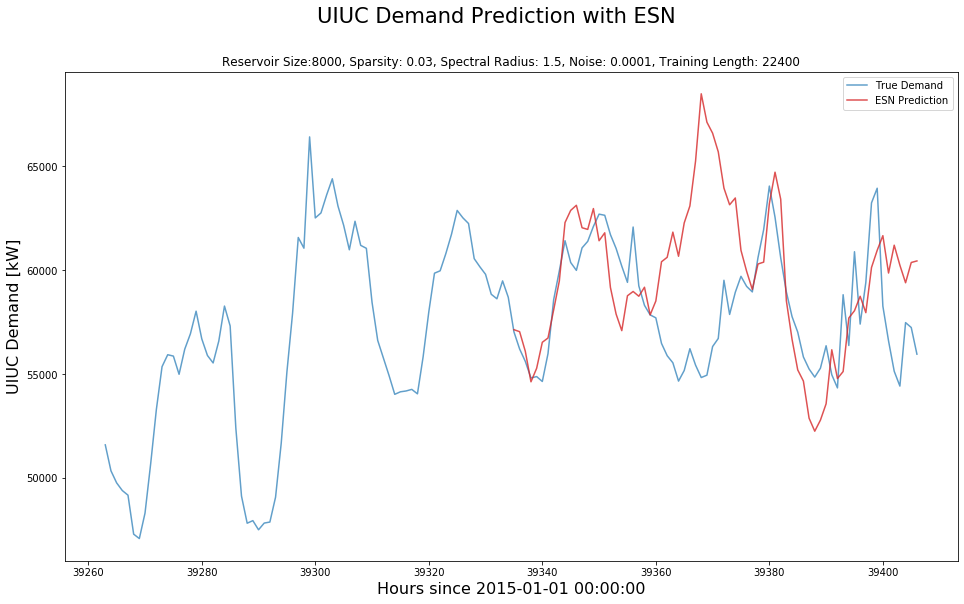

In [20]:
plt.figure(figsize=(16,9))
plt.suptitle("UIUC Demand Prediction with ESN", fontsize=21)
plt.title(param_string(nonopt_params))
plt.ylabel("UIUC Demand [kW]", fontsize=16)
plt.xlabel(f"Hours since {time_range[0]}", fontsize=16)
# plot the truth
plt.plot(hour_range[-2*futureTotal:],norm*demand_norm[-2*futureTotal:],'b',label="True Demand", 
         alpha=0.7,
         color='tab:blue')
# # plot the prediction
plt.plot(hour_range[-futureTotal:], norm*nonopt_pred.T[0],  alpha=0.8, 
         label='ESN Prediction',
         color='tab:red',
         linestyle='-')
plt.legend()